# Project Objective


Supervised Learning
→ Predict average student score

Unsupervised Learning
→ Cluster students into High/Medium/Low performance groups


I built a student performance prediction system using both supervised and unsupervised learning. The regression model predicts student scores, and clustering groups students into performance levels. I used data preprocessing, feature encoding, scaling, and visualization techniques. I also learned to interpret low R² scores and improve model design based on EDA insights.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [90]:
df = pd.read_csv('../dataset/StudentsPerformance.csv')

In [91]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


# EDA and Visualizations

In [92]:

print(f" Description of data: {df.describe()}")
print(f" Null values in data : {df.isnull().sum()}")
print(f" Duplicate values in data: {df.duplicated().sum()}")



 Description of data:        math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000
 Null values in data : gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64
 Duplicate values in data: 0


In [93]:
# combining three scores to make an average score

df['Average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

In [94]:
df['Average_score']

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: Average_score, Length: 1000, dtype: float64

**Target Variable Distribution - Average_Score**

The distribution of average scores is slightly left-skewed, indicating most students scored moderately well, with fewer very low scores.

Text(0.5, 1.0, 'Distribution of Average Student Score')

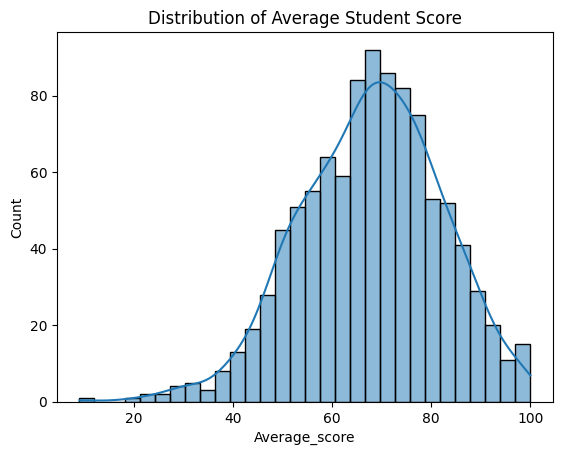

In [100]:
sns.histplot(df['Average_score'], bins=30, kde=True)
plt.title("Distribution of Average Student Score")


**Gender Count plot, Test Preparation count plot, parental edu level**

The dataset has a fairly balanced distribution of male and female students

A majority of students did not complete the test preparation course

Most parents had education levels around high school or some college




<Axes: xlabel='gender', ylabel='count'>

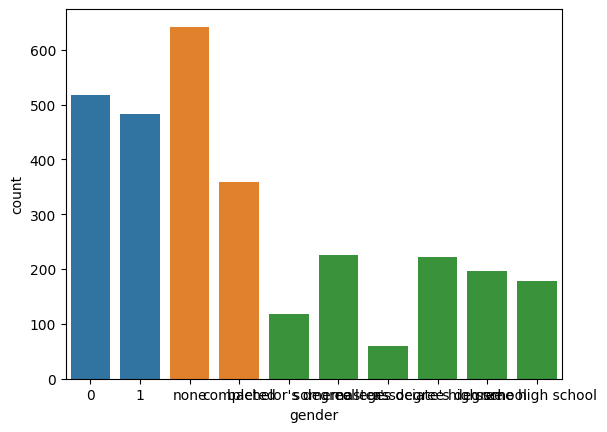

In [101]:
sns.countplot(x='gender', data=df)
sns.countplot(x='test preparation course', data=df)
sns.countplot(x='parental level of education', data=df)


**boxplot - compare groups** 

On average, female students tend to score slightly higher than male students, especially in reading and writing.

Students who completed the test preparation course performed better on average, indicating that the course has a positive impact on performance.


<Axes: xlabel='gender', ylabel='Average_score'>

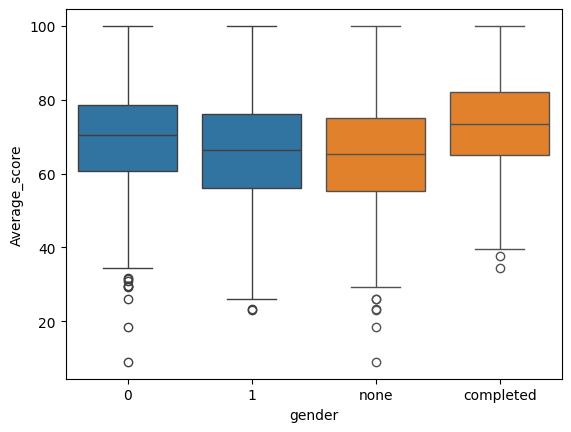

In [ ]:


sns.boxplot(x='gender', y='Average_score', data=df)
sns.boxplot(x='test preparation course', y='Average_score', data=df)


**Grouped Bar Charts**

Students whose parents had higher levels of education (like Bachelor's or Master's degrees) generally performed better.

Text(0.5, 1.0, 'Avg Score by Parental Education')

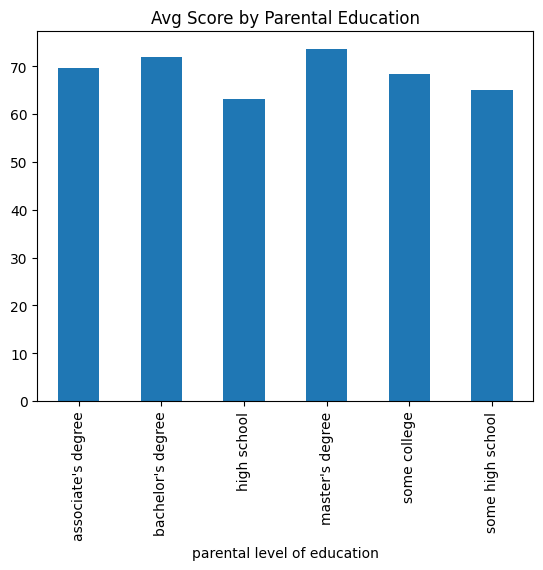

In [ ]:


df.groupby('parental level of education')['Average_score'].mean().plot(kind='bar')
plt.title("Avg Score by Parental Education")


**Pairplot of Subject Scores**

There's a clear linear relationship between reading and writing scores

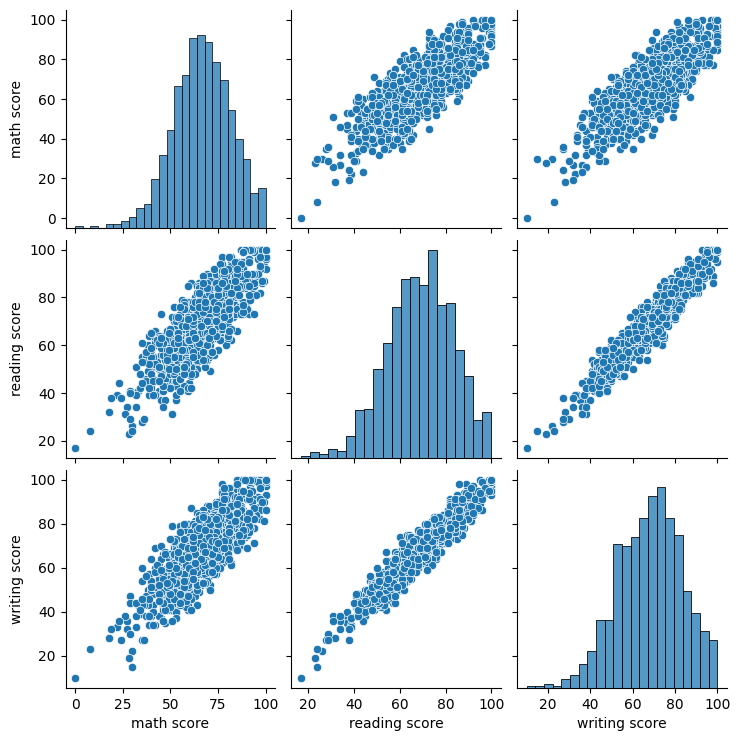

In [105]:
sns.pairplot(df[['math score', 'reading score', 'writing score']])


In [95]:
df['parental level of education'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [96]:
df['race/ethnicity'].unique()


array(['group B', 'group C', 'group A', 'group D', 'group E'],
      dtype=object)

In [97]:
df['gender'].unique()

array(['female', 'male'], dtype=object)

In [98]:
df['test preparation course'].unique()

array(['none', 'completed'], dtype=object)

In [99]:
# gender and lunch - binary encoding

df['gender'] = df['gender'].map({
    "female" : 0,
    "male" : 1
})

In [75]:
df['lunch'] = df['lunch'].map({
    "free/reduced" : 0,
    "standard" : 1
})

In [76]:
# parental education - manual encoding

education_mapping = {
    "some high school" : 0,
    "high school" : 1,
    "some college" : 2,
    "associate's degree" : 3,
    "bachelor's degree" : 4,
    "master's degree" : 5
}

df['parental level of education'] = df['parental level of education'].map(education_mapping)

# test preparation - binary ordinal encoding

df['test preparation course'] = df['test preparation course'].map({
    "none": 0,
    "completed" : 1
})


In [77]:
# race / Ethnicity - no relation, no one is greater than other. - one hot encoding

df = pd.get_dummies(df,columns = ['race/ethnicity'], drop_first = True)



In [80]:
df.dtypes

gender                           int64
parental level of education      int64
lunch                            int64
test preparation course          int64
math score                       int64
reading score                    int64
writing score                    int64
Average_score                  float64
race/ethnicity_group B            bool
race/ethnicity_group C            bool
race/ethnicity_group D            bool
race/ethnicity_group E            bool
dtype: object

In [ ]:
## converting to 0 and 1 values in group b,c,d,e

df = df.astype({
    col:'int' for col in df.columns
    if df[col].dtype == 'bool'
})

In [82]:
# final cleaned data 
df.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,Average_score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,0,4,1,0,72,72,74,72.666667,1,0,0,0
1,0,2,1,1,69,90,88,82.333333,0,1,0,0
2,0,5,1,0,90,95,93,92.666667,1,0,0,0
3,1,3,0,0,47,57,44,49.333333,0,0,0,0
4,1,2,1,0,76,78,75,76.333333,0,1,0,0


# Supervised Learning - Linear Regression



Train Test Split

In [ ]:
# feature selection
X = df.drop(columns=['math score', 'reading score', 'writing score', 'Average_score'])
y = df['Average_score']


#train test split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Standardization

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [85]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

In [86]:
from sklearn.metrics import mean_squared_error,r2_score

y_pred = model.predict(X_test_scaled)
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R2 Score: 0.17755135549942613
Mean Squared Error: 176.30549218124193


In [88]:
result = pd.DataFrame({
    'Actual' : y_test,
    'Predicted' : y_pred
})
print(result.head(10))

        Actual  Predicted
521  87.000000  70.741430
737  64.000000  66.871135
740  75.000000  71.071443
660  74.666667  55.786005
411  81.666667  78.172236
678  78.000000  60.275467
626  67.333333  64.297186
513  59.000000  72.910611
859  77.333333  57.371505
136  48.666667  68.751162



## Key notes from EDA:
- Female students had slightly higher reading and writing scores on average.
- Students who completed test preparation had significantly better scores.
- Students with bachelor's or master's level parental education generally performed better.
- Group E had the highest concentration of top performers.
